# Playground for Building Function Approximator Tools

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Callable
import math
import torch
from torch.utils.tensorboard import SummaryWriter
import os
import shutil

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Minimum Sample Size for Catching Coin Toss Cheaters
Inspired by this video: https://www.youtube.com/watch?v=XTcP4oo4JI4&t=1178s

Let, $p_f, p_b$ be the probabilities of a fair and biased coin respectively.

Let $\alpha, \beta$ be the desired FPR and effect size target respectively.

We want to find $n$ := the minimum sample size to satisfy those targets where the test is: identify a cheater (positive) if they hit more than $T$ heads ($T$ is determined based on those parameters).

Once we define a function, we'll fit it using the function approximator framework.

In [3]:
# utility matrix that caches n choose k values for up to MAX_N for faster computation
MAX_N = 1000

# M[n, k] n > 1, 0 <= k <= n
cached_n_choose_k = np.zeros((MAX_N + 1, MAX_N + 1))
for n in range(1, MAX_N + 1):
    for k in range(n + 1):
        cached_n_choose_k[n, k] = math.comb(n, k)

In [4]:
def binomial_pdf(n: int, p: float, k: float) -> float:
    return cached_n_choose_k[n, k] * p**k * (1-p)**(n-k)

In [5]:
def compute_min_threshold_for_alpha(p: float, alpha: float, n: int) -> int:
    # find the minimum T such that probability of hitting at least T heads on n tosses is <= alpha

    total_probability = 0

    # iterate backwards
    for t in range(n, -1, -1):
        total_probability += binomial_pdf(n, p, t)

        if total_probability > alpha:
            return t + 1
    
    # if we get here, something went wrong - the final probability should be 1 and alpha < 1
    raise ValueError(f"Ensure alpha is < 1.0")

In [6]:
def compute_statistical_power(p: float, n: int, t: int) -> float:
    total_probability = 0
    for k in range(t, n + 1):
        total_probability += binomial_pdf(n, p, k)
    
    return total_probability


In [7]:
def min_sample_for_test(p_f: float, p_b: float, alpha: float, beta: float) -> Optional[int]:
    # validation logic
    assert 0 <= p_f <= 1
    assert 0 <= p_b <= 1
    assert p_f < p_b
    assert 0 < alpha < 1
    assert 0 < beta < 1

    for n in range(1, MAX_N + 1):
        t = compute_min_threshold_for_alpha(p_f, alpha, n)
        power = compute_statistical_power(p_b, n, t)
        if power >= beta:
            return n
    
    return MAX_N + 1


In [8]:
min_sample_for_test(
    p_f=0.5,
    p_b=0.75,
    alpha=0.05,
    beta=0.8,
)

23

In [9]:
# static parameter values
parameter_values = {
    "p_f": 0.5,
    "p_b": 0.75,
    "alpha": 0.05,
    "beta": 0.8,
}

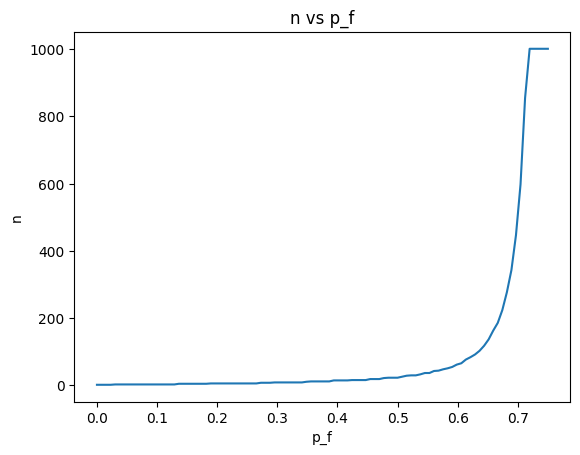

In [10]:
# plot n vs p_f fixing the other parameters
p_f = np.linspace(0, parameter_values["p_b"] - 0.0001, 100)
n_vals = np.array([min_sample_for_test(p_f, parameter_values["p_b"], parameter_values["alpha"], parameter_values["beta"]) for p_f in p_f])
plt.plot(p_f, n_vals)
plt.xlabel("p_f")
plt.ylabel("n")
plt.title("n vs p_f")
plt.show()

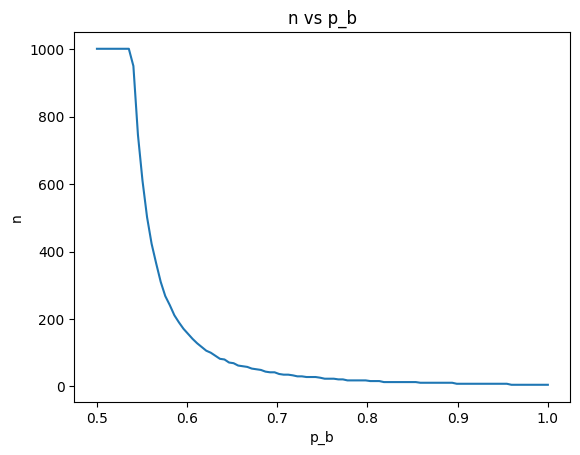

In [11]:
# plot n vs p_b fixing the other parameters
p_b = np.linspace(parameter_values["p_f"] + 0.0001, 1, 100)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], p_b, parameter_values["alpha"], parameter_values["beta"]) for p_b in p_b])
plt.plot(p_b, n_vals)
plt.xlabel("p_b")
plt.ylabel("n")
plt.title("n vs p_b")
plt.show()

In [12]:
min_sample_for_test(parameter_values["p_f"], 1.0, parameter_values["alpha"], parameter_values["beta"])

5

In [13]:
min_sample_for_test(0.0, parameter_values["p_f"], parameter_values["alpha"], parameter_values["beta"])

3

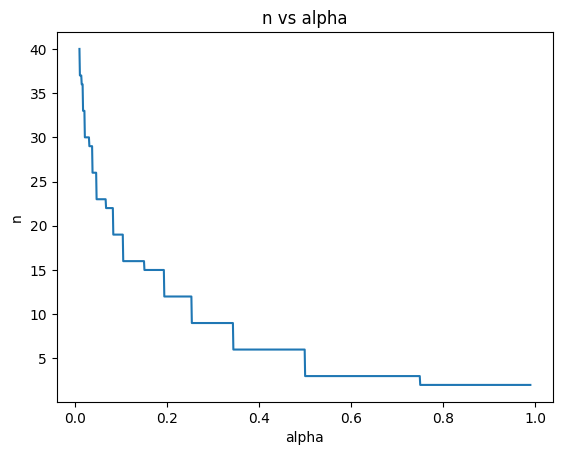

In [14]:
# plot n vs alpha fixing the other parameters
alpha = np.linspace(0.01, 0.99, 1000)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], parameter_values["p_b"], alpha, parameter_values["beta"]) for alpha in alpha])
plt.plot(alpha, n_vals)
plt.xlabel("alpha")
plt.ylabel("n")
plt.title("n vs alpha")
plt.show()

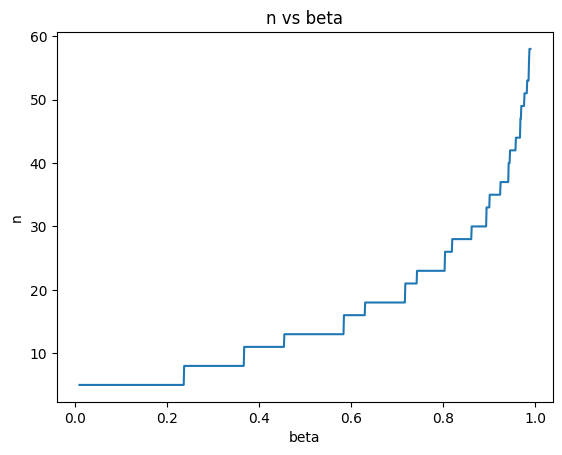

In [15]:
# plot n vs beta fixing the other parameters
beta = np.linspace(0.01, 0.99, 1000)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], parameter_values["p_b"], parameter_values["alpha"], beta) for beta in beta])
plt.plot(beta, n_vals)
plt.xlabel("beta")
plt.ylabel("n")
plt.title("n vs beta")
plt.show()

### Approximate this Function
We take a stab at approximating this function $f(p_f, p_b, \alpha, \beta) \mapsto \mathbb{Z}_+$

In [16]:
# imports
from approximator.fitter import Fitter
from approximator.input_sampler import InputSampler

In [46]:
# we write our custom input sampler
class MinSizeProblemInputSampler(InputSampler):
    def sample(self, batch_size: int) -> List[List[float]]:
        # sample p_f between 0 and 0.5
        p_f = np.random.uniform(0, 0.5, batch_size)
        # sample p_b between 0.6 and 1
        p_b = np.random.uniform(0.6, 1, batch_size)
        # sample alpha between 0.01 and 0.2
        alpha = np.random.uniform(0.01, 0.2, batch_size)
        # sample beta between 0.6 and 1.0
        beta = np.random.uniform(0.6, 1, batch_size)

        return [[p_f[i], p_b[i], alpha[i], beta[i]] for i in range(batch_size)]
        

In [47]:
sampler = MinSizeProblemInputSampler()
sampler.sample(5)

[[np.float64(0.22996795149331178),
  np.float64(0.6791661564120827),
  np.float64(0.1271251891675025),
  np.float64(0.9182504615853064)],
 [np.float64(0.1574902332545129),
  np.float64(0.7498227024914883),
  np.float64(0.12600922908079765),
  np.float64(0.9064796140424907)],
 [np.float64(0.18171207318700694),
  np.float64(0.6245276736563189),
  np.float64(0.05684704755977063),
  np.float64(0.6207554786374831)],
 [np.float64(0.35085580304341946),
  np.float64(0.7362705489803975),
  np.float64(0.17151466135302773),
  np.float64(0.8085501679859401)],
 [np.float64(0.07193348430840668),
  np.float64(0.8792543517904684),
  np.float64(0.1435609055367031),
  np.float64(0.975686824430248)]]

In [67]:
# we write our custom fitter

# we evaluate and plot the loss and MSE on another sample (mimicking a validation sample) to ensure the model is learning

class MinSizeProblemFitter(Fitter):
    def __init__(self, fn: Callable, input_sampler: InputSampler, train_batch_size: int = 32, eval_batch_size: int = 1000, num_steps: int = 10000, eval_steps: int = 100):
        # self._loss = torch.nn.PoissonNLLLoss(log_input=False, full=False)
        self._loss = torch.nn.MSELoss()
        self._num_steps = num_steps
        self._eval_steps = eval_steps
        self._train_batch_size = train_batch_size
        self._eval_batch_size = eval_batch_size
        self._model = self._construct_model()
        self._optimizer = torch.optim.Adam(self._model.parameters(), lr=0.01)

        self._num_fits = 0
        # initialize a writer for metrics
        # remove the runs/ directory if it exists
        if os.path.exists("runs/"):
            shutil.rmtree("runs/")
        self._writer = SummaryWriter(f"runs/min_size_problem_{self._num_fits}")

        super().__init__(fn, input_sampler)

    def fit(self) -> Callable: 
        for step_idx in range(self._num_steps):
            self._step()

            if step_idx% self._eval_steps == 0:
                self._evaluate_and_log(step_idx)

        self._num_fits += 1
        self._writer = SummaryWriter(f"runs/min_size_problem_{self._num_fits}")

        def fitted_fn(p_f: float, p_b: float, alpha: float, beta: float) -> float:
            model_out = self._model(torch.tensor([p_f, p_b, alpha, beta], dtype=torch.float32)).item()
            return round(model_out)
        
        return fitted_fn

    def _construct_model(self) -> torch.nn.Module:
        last_linear_layer = torch.nn.Linear(64, 1)
        # we custom initialize this to avoid zero gradients due to the hardtanh
        torch.nn.init.uniform_(last_linear_layer.weight, -0.1, 0.1)
        torch.nn.init.constant_(last_linear_layer.bias, 500)

        return torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            last_linear_layer,
            # torch.nn.ReLU(),
            # torch.nn.Hardtanh(min_val=1.0, max_val=1001.0),
        )
    
    def _evaluate_and_log(self, step_idx: int) -> None:
        """Evaluation and logging"""

        # sample a batch of inputs and outputs
        inputs, targets = self._generate_batch(self._eval_batch_size)

        # forward pass
        model_outputs = self._forward(inputs)

        # compute loss tensor
        targets = torch.tensor(targets, dtype=torch.float32)
        loss = self._loss(model_outputs, targets)

        # compute MSE
        mse = torch.mean((model_outputs - targets) ** 2)

        # compute poisson NLL
        poisson_nll = torch.mean(torch.nn.functional.poisson_nll_loss(model_outputs, targets, log_input=False, full=True))

        # log the loss and MSE
        self._writer.add_scalar("loss", loss, step_idx)
        self._writer.add_scalar("MSE", mse, step_idx)
        self._writer.add_scalar("Poisson NLL", poisson_nll, step_idx)

        # print out some values
        for i in range(10):
            print(f"Step {step_idx}")
            print(f"Inputs {inputs[i]}")
            print(f"Target: {targets[i]}, Model Output: {model_outputs[i].item()}")
    
    def _step(self) -> None:
        """
        Perform one optimization step
        """

        # zero the gradients
        self._optimizer.zero_grad()

        # sample a batch of inputs and outputs
        inputs, targets = self._generate_batch(self._train_batch_size)

        # forward pass
        model_outputs = self._forward(inputs)

        # compute loss tensor
        targets = torch.tensor(targets, dtype=torch.float32)
        loss = self._loss(model_outputs, targets)

        # backward pass
        loss.backward()

        # optimization step
        self._optimizer.step()

    def _forward(self, batch: List[List[float]]) -> torch.Tensor:
        # compute a forward pass and return the output tensor
        # convert to tensor
        inputs = torch.tensor(batch, dtype=torch.float32)

        # forward pass on the model
        return self._model(inputs)


In [68]:
sampler = MinSizeProblemInputSampler()

In [69]:
approximator = MinSizeProblemFitter(
    fn=min_sample_for_test,
    input_sampler=sampler,
    train_batch_size=32,
    eval_batch_size=1000,
    num_steps=10000,
    eval_steps=100,
)

In [70]:
approximated_fn = approximator.fit()

Step 0
Inputs [np.float64(0.34381477525032744), np.float64(0.6551180927500857), np.float64(0.08829580393338046), np.float64(0.9651414029582334)]
Target: 26.0, Model Output: 499.84130859375
Step 0
Inputs [np.float64(0.21408349297859208), np.float64(0.8605635483055886), np.float64(0.0630837665952124), np.float64(0.8269950670738193)]
Target: 4.0, Model Output: 499.8362731933594
Step 0
Inputs [np.float64(0.2076012528422823), np.float64(0.7750192440243653), np.float64(0.11193132777849368), np.float64(0.6891247504911344)]
Target: 3.0, Model Output: 499.8405456542969
Step 0
Inputs [np.float64(0.23389091196178186), np.float64(0.6404397458099781), np.float64(0.14241135620448186), np.float64(0.6269204001781852)]
Target: 3.0, Model Output: 499.8457946777344
Step 0
Inputs [np.float64(0.17397180449402772), np.float64(0.8594293057369315), np.float64(0.1799984465896101), np.float64(0.7310678515009711)]
Target: 1.0, Model Output: 499.8340148925781
Step 0
Inputs [np.float64(0.24326952130980078), np.flo